In [0]:
# %******************************************************************************************************************%
# % The AIC19 benchmark is captured by 40 cameras in real-world traffic surveillance environment.                    %
# % A total of 666 vehicles are annotated. 333 vehicles are used for training. The remaining 333 vehicles are for    %
# % testing.                                                                                                         %
# % There are 56277 images in total. 18290 images are in the test set, and 36935 images are in the training set.     %
# %******************************************************************************************************************%

# Content in the directory:
# 1. "image_query/". This dir contains 1052 images as queries. 
# 2. "image_test/". This dir contains 18290 images for testing. 
# 3. "image_train/". This dir contains 36935 images for training. 
# 4. "name_query.txt". It lists all query file names.
# 5. "name_test.txt". It lists all test file names.
# 6. "name_train.txt". It lists all train file names.
# 7. "test_track.txt" & "test_track_id.txt". They record all testing tracks. Each track contains multiple images of the same vehicle captured by one camera.
# 8. "train_track.txt" & "train_track_id.txt". They record all training tracks. Each track contains multiple images of the same vehicle captured by one camera.
# 9. "train_label.xml". It lists the labels of vehicle ID and camera ID for training.
# 10. "train_label.csv". It lists the labels of vehicle ID in CSV format for training. 
# 11. "tool/visualize.py" & "tool/dist_example/". It is a Python tool for visualizing the results of vehicle re-identificaition, with an example of input data provided. 
# 12. "DataLicenseAgreement_AICityChallenge.pdf". The license agreement for the usage of this dataset. 

# If you have any question, please contact aicitychallenge2019@gmail.com.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
#### !cp aic19-track2-reid.zip ../gdrive/My\ Drive/aic19-track2-reid.zip
!cp drive/My\ Drive/aic19-track2-reid.zip aic19-track2-reid.zip 
!unzip -qq aic19-track2-reid.zip

In [0]:
from pathlib import Path
import xml.etree.ElementTree as ET
from collections import defaultdict

dataset_path = Path('.')

ID_to_image_dict = defaultdict(lambda: [])
with open(dataset_path/'train_label.xml','r') as f:
    ef = ET.fromstring(f.read())
    items = ef.getchildren()
    image_to_attribute = list(items[0].iter('Item'))
    image_to_attribute = {item.attrib["imageName"]:item.attrib for item in image_to_attribute}
    for key, item in image_to_attribute.items():
        ID_to_image_dict[item["vehicleID"]].append(item)

In [5]:
image_to_attribute['021284.jpg']

{'cameraID': 'c026', 'imageName': '021284.jpg', 'vehicleID': '0347'}

In [6]:
len(ID_to_image_dict)

333

In [0]:
def get_train_tasks():
    with open(dataset_path/'train_track.txt', "r") as fo:
        lines = fo.readlines()
    lines = [line.split(' ')[:-1] for line in lines]
    return lines

def get_images(filename):
    with open(dataset_path/filename, "r") as fo:
        lines = fo.readlines()
    lines = [line[:-1] for line in lines]
    return lines

def get_images_from_tracks(tracks):
    images = [image_to_attribute[image] for track in tracks for image in track]
    return images

In [0]:
train_tracks_total = get_train_tasks()

# Filter those tracks which have less than 2 images
train_tracks_total = [track for track in train_tracks_total if len(track) >=2]

In [9]:
train_tracks_total[0]

['000019.jpg',
 '030183.jpg',
 '004066.jpg',
 '025702.jpg',
 '004614.jpg',
 '023792.jpg',
 '033970.jpg',
 '012260.jpg',
 '026491.jpg',
 '030939.jpg',
 '015186.jpg',
 '030295.jpg',
 '035919.jpg',
 '036632.jpg',
 '013990.jpg',
 '009604.jpg',
 '012136.jpg',
 '018695.jpg',
 '000781.jpg',
 '035058.jpg']

In [0]:
import math
import matplotlib.pyplot as plt

def show_images_in_track(track):
    img_folder_path = Path('image_train')
    num_images = len(track)
    num_cols = 5
    num_rows = math.ceil(1.0*num_images/num_cols)
    if num_rows == 1:
        num_cols = num_images
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(10,10))

    row = 0
    col = 0
    for i, img_name in enumerate(track):
        img = plt.imread(img_folder_path/img_name)
        if num_rows == 1:
            current_axis = axs[col]
        else:
            current_axis = axs[row, col]
        current_axis.axis("off")
        current_axis.set_title(img_name)
        current_axis.imshow(img)

        col += 1

        if col == num_cols:
            col = 0
            row += 1
    
    if num_rows*num_cols > num_images:
        remaining_axes = num_rows*num_cols - num_images 
        for _ in range(remaining_axes):
            current_axis = axs[row, col]
            current_axis.axis("off")
            col += 1
            if col == num_cols:
                col = 0
                row += 1
    
    plt.show()

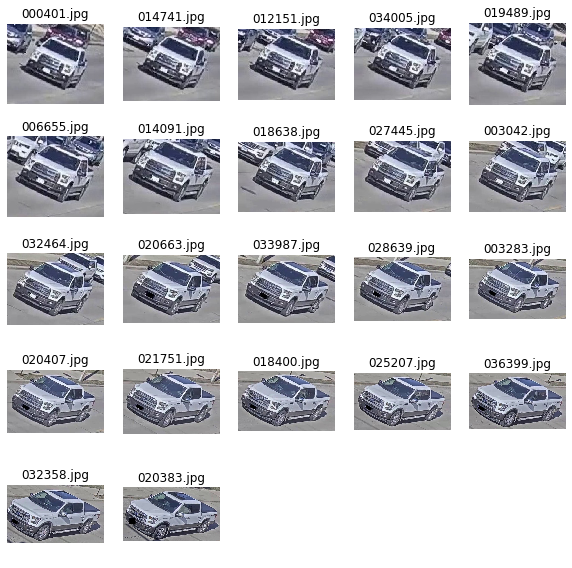

In [11]:
show_images_in_track(train_tracks_total[24])

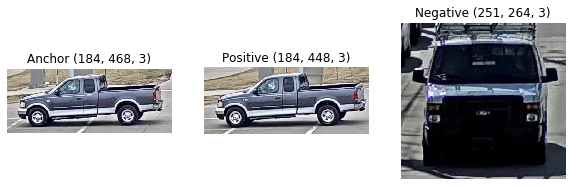

In [12]:
import numpy as np

def create_triplet_task(positive_track, negative_track):

    # positive_track, negative_track = np.random.choice(train_tracks, size=2, replace=False)
    anchor_image, positive_image = np.random.choice(positive_track, size=2, replace=False)
    negative_image = np.random.choice(negative_track)

    return anchor_image, positive_image, negative_image

def visualize_triplet_task(anchor_image, positive_track, negative_image):
    img_folder_path = Path('image_train')
    fig, axs = plt.subplots(1, 3, figsize=(10,10), gridspec_kw={'hspace': 0.2})
    images = [anchor_image, positive_track, negative_image]
    title = ["Anchor", "Positive", "Negative"]
    row = 0
    col = 0
    for i, img_name in enumerate(images):
        img = plt.imread(img_folder_path/img_name)
        axs[i].axis("off")
        axs[i].set_title(title[i] + " " + str(img.shape))
        axs[i].imshow(img)
    plt.show()

visualize_triplet_task(*create_triplet_task(*np.random.choice(train_tracks_total, size=2, replace=False)))

In [0]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
from PIL import Image

class TripletDataset(Dataset):

    def __init__(self, tracks, image_path, image_size):
        self.tracks = tracks
        self.image_path = image_path
        self.image_size = image_size
    
    def __len__(self):
        return len(self.tracks)
    
    def applyTransforms(self, image):
        image_resized = TF.resize(image, self.image_size)
        image_tensor = TF.to_tensor(image_resized)
        return image_tensor
    
    def __getitem__(self, idx):
        positive_track = self.tracks[idx]
        negative_track_index = (idx + np.random.randint(1, len(self.tracks))) % len(self.tracks)
        assert idx != negative_track_index
        negative_track = self.tracks[negative_track_index]
        anchor_image, positive_image, negative_image = create_triplet_task(positive_track, negative_track)
        images = [anchor_image, positive_image, negative_image]
        images = [Image.open(self.image_path/image) for image in images]
        images = [self.applyTransforms(image) for image in images]
        anchor_image, positive_image, negative_image = images
        return anchor_image, positive_image, negative_image

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvBatchNormBlock(nn.Module):

    def __init__(self, in_channels, out_channels):
        super(ConvBatchNormBlock, self).__init__()
        self.conv_layer = nn.Conv2d(in_channels, out_channels, 3)
        self.max_pooling = nn.MaxPool2d(2, 2)
        self.batch_norm = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        out = self.conv_layer(x)
        out = self.batch_norm(out)
        out = F.relu(out)
        out = self.max_pooling(out)
        return out

In [0]:
class EmbeddingNet(nn.Module):

    def __init__(self):
        super(EmbeddingNet, self).__init__()
        self.conv_block1 = ConvBatchNormBlock(3, 16)
        self.conv_block2 = ConvBatchNormBlock(16, 32)
        self.conv_block3 = ConvBatchNormBlock(32, 64)
        self.conv_block4 = ConvBatchNormBlock(64, 128)
        self.conv_block5 = ConvBatchNormBlock(128, 256)
        self.flatten_adaptive_pooling = nn.AdaptiveAvgPool2d((1, 1))
    
    def forward(self, x):
        batch_size = x.shape[0]
        out = self.conv_block1(x)
        out = self.conv_block2(out)
        out = self.conv_block3(out)
        out = self.conv_block4(out)
        out = self.conv_block5(out)
        out = self.flatten_adaptive_pooling(out)
        out = out.view(batch_size, -1)
        return out

In [0]:
class TripletNet(nn.Module):
    def __init__(self):
        super(TripletNet, self).__init__()
        self.embeddingnet = EmbeddingNet()

    def getEmbedding(self, x):
        return self.embeddingnet(x)
        
    def forward(self, x, y, z):
        embedded_x = self.embeddingnet(x)
        embedded_y = self.embeddingnet(y)
        embedded_z = self.embeddingnet(z)
        dist_a = F.pairwise_distance(embedded_x, embedded_y, 2)
        dist_b = F.pairwise_distance(embedded_x, embedded_z, 2)
        return dist_a, dist_b, embedded_x, embedded_y, embedded_z

In [17]:
from sklearn.model_selection import train_test_split

train_tracks, val_tracks = train_test_split(train_tracks_total, test_size=0.10, random_state=42)
print("Training Size - {}".format(len(train_tracks)))
print("Validation Size - {}".format(len(val_tracks)))

Training Size - 1665
Validation Size - 185


In [18]:
from tqdm import tqdm_notebook, trange, tqdm
import torch.optim as optim

NUM_EPOCHS = 5
triplet_model = TripletNet().cuda()
criterion = nn.MarginRankingLoss(margin = 1)
optimizer = optim.Adam(triplet_model.parameters(), lr=0.001)

losses = []

triplet_dataset = TripletDataset(train_tracks, Path('image_train'), (512, 512))
triplet_dataloader = DataLoader(triplet_dataset, batch_size=32, shuffle=True, num_workers=4)

for epoch in trange(NUM_EPOCHS):

    for triplet_batch in triplet_dataloader:
        anchors, positives, negatives = triplet_batch
        anchors, positives, negatives = anchors.cuda(), positives.cuda(), negatives.cuda()
        dist_a, dist_b, embedded_x, embedded_y, embedded_z = triplet_model(anchors, positives, negatives)
        target = torch.FloatTensor(dist_a.size()).fill_(1).cuda()
        loss_triplet = criterion(dist_a, dist_b, target)
        # loss_embedd = embedded_x.norm(2) + embedded_y.norm(2) + embedded_z.norm(2)
        loss = loss_triplet
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

100%|██████████| 5/5 [02:36<00:00, 31.29s/it]


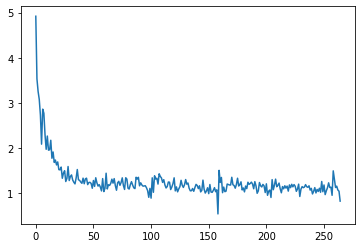

In [19]:
plt.plot(losses)

In [0]:
class ImageDataset(Dataset):

    def __init__(self, images, root_folder, image_size):
        self.images = images
        self.root_folder = root_folder
        self.image_size = image_size
    
    def __len__(self):
        return len(self.images)
    
    def applyTransforms(self, image):
        image_resized = TF.resize(image, self.image_size)
        image_tensor = TF.to_tensor(image_resized)
        return image_tensor
    
    def __getitem__(self, idx):
        image = Image.open(self.root_folder/self.images[idx]["imageName"])
        image = self.applyTransforms(image)
        return image

In [0]:
train_images = get_images_from_tracks(train_tracks)
val_images = get_images_from_tracks(val_tracks)

split_index = len(train_images)
total_images = train_images + val_images
total_images_dataset = ImageDataset(total_images, Path("image_train"), (256, 256))
total_images_dataloader = DataLoader(total_images_dataset, num_workers=4, batch_size=64, shuffle=False)

In [22]:
%%time
total_embeddings = []
with torch.no_grad():
    triplet_model = triplet_model.eval()
    for image_batch in tqdm(total_images_dataloader):
        image_batch = image_batch.cuda()
        batch_embeddings = triplet_model.getEmbedding(image_batch)
        total_embeddings.append(batch_embeddings.cpu())
total_embeddings = torch.cat(total_embeddings, dim=0).numpy()
val_embeddings = total_embeddings[split_index:, :]

100%|██████████| 548/548 [01:02<00:00,  8.78it/s]

CPU times: user 11.4 s, sys: 7.98 s, total: 19.3 s
Wall time: 1min 2s


In [23]:
total_embeddings.shape

(35012, 256)

In [0]:
from sklearn.metrics import pairwise_distances, average_precision_score

In [25]:
%%time
distances = pairwise_distances(val_embeddings, total_embeddings)

CPU times: user 5.2 s, sys: 2.97 s, total: 8.17 s
Wall time: 2.24 s


In [26]:
# Lower the distance => Better the match
%%time
best_matches = np.argsort(distances, axis=1)

CPU times: user 9.5 s, sys: 136 ms, total: 9.63 s
Wall time: 9.63 s


In [27]:
best_matches.shape

(3566, 35012)

In [28]:
best_matches[0:5, :5]

array([[31446, 20235,  1418, 16671, 29880],
       [31447, 23943, 11623, 10789,  6584],
       [31448, 24248, 23357, 13158, 30325],
       [31449,  8349,  5366, 25594, 11625],
       [31450,  6243,  2662, 34145, 15620]])

In [29]:
total_images[split_index]

{'cameraID': 'c026', 'imageName': '004042.jpg', 'vehicleID': '0444'}

In [30]:
total_images[23068]

{'cameraID': 'c023', 'imageName': '014948.jpg', 'vehicleID': '0437'}

In [0]:
def indices_to_vehicle_ids(matches, total_images, ID_to_image_dict, split_index=0):
    num_queries = matches.shape[0]
    num_database = matches.shape[1]
    id_matches = np.empty_like(matches, dtype=object)
    # expected_matches = []
    for query in trange(num_queries):
        for database in range(num_database):
            id_matches[query, database] = total_images[matches[query, database]]['vehicleID']
        # query_matches = ID_to_image_dict[total_images[split_index + query]['vehicleID']]
        # query_matches = np.array([item['vehicleID'] for item in query_matches])
        # expected_matches.append(query_matches)
    return id_matches

In [32]:
id_matches = indices_to_vehicle_ids(best_matches, total_images, ID_to_image_dict, split_index)

100%|██████████| 3566/3566 [00:55<00:00, 64.08it/s]


In [0]:
def get_precision(ids, index, max_num_elements = 1000):
    required_id = ids[index, 0]

    # num_possible_images = ID_to_image_dict[id_matches[0, 0]]
    # same_query_indices = np.argwhere(id_matches[:, 0] == id_matches[index, 0])
    non_query_indices = np.argwhere(id_matches[index, :max_num_elements] != id_matches[index, 0])

    true_positives = np.cumsum(id_matches[index, :max_num_elements+1] == required_id)
    true_positives[non_query_indices] = 0
    true_positives = true_positives[1:]
    # print(true_positives)
    num_values = true_positives[-1]
    # num_values = np.count_nonzero(id_matches[index, :] == id_matches[index, 0])

    true_positives = true_positives/(np.arange(max_num_elements)+1)
    # print(true_positives)
    true_positives = np.sum(true_positives)
    # false_positives = np.cumsum(np.sum(id_matches[non_query_indices, :max_num_elements] == required_id, axis=0))
    # num_matches = np.cumsum(ids[index] == required_id) - 1

    if num_values == 0:
        return 0
    average_precision = true_positives*1.0/num_values

    # print(true_positives)
    # print(false_positives)
        
    return average_precision

In [164]:
get_precision(id_matches, 0)

0.021871290876150064

In [169]:
ap_list = []

for query in trange(id_matches.shape[0]):
    average_precision = get_precision(id_matches, query, max_num_elements=1000)
    ap_list.append(average_precision)

np.mean(ap_list)

100%|██████████| 3566/3566 [00:00<00:00, 10341.90it/s]


0.08933799927594242

In [0]:
!wget https://repo.continuum.io/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh && bash Miniconda3-4.5.4-Linux-x86_64.sh -bfp /usr/local

In [0]:
import sys
sys.path.append('.')
sys.path.append('/usr/local/lib/python3.6/site-packages')
sys.path.append('/root/.local/lib/python3.6/site-packages')

In [0]:
!conda install faiss-gpu -c pytorch

In [166]:
%%time
import faiss                   # make faiss available
index = faiss.IndexFlatL2(total_embeddings.shape[1])   # build the index
index.add(total_embeddings)
print(index.is_trained)

True
CPU times: user 9.7 ms, sys: 896 µs, total: 10.6 ms
Wall time: 11 ms


In [167]:
index.ntotal

35012

In [170]:
%%time
D, I = index.search(val_embeddings, 1000)

CPU times: user 2.29 s, sys: 47.9 ms, total: 2.34 s
Wall time: 1.17 s


In [171]:
I.shape

(3566, 1000)

In [172]:
faiss_id_matches = indices_to_vehicle_ids(I, total_images, ID_to_image_dict, split_index)

100%|██████████| 3566/3566 [00:01<00:00, 2480.96it/s]


In [173]:
ap_list = []

for query in trange(faiss_id_matches.shape[0]):
    average_precision = get_precision(faiss_id_matches, query)
    ap_list.append(average_precision)

np.mean(ap_list)

100%|██████████| 3566/3566 [00:00<00:00, 11547.88it/s]


0.08933799927594242

In [96]:
!python -m pip install --target=. annoy

Processing /root/.cache/pip/wheels/d3/d7/68/3795670ef4c6781fc10df0d6cf83b922244aa28cd9489d1176/annoy-1.16.2-cp36-cp36m-linux_x86_64.whl


In [174]:
%%time
from annoy import AnnoyIndex

f = total_embeddings.shape[1]
t = AnnoyIndex(f, 'euclidean')  # Length of item vector that will be indexed
for i in range(total_embeddings.shape[0]):
    v = total_embeddings[i]
    t.add_item(i, v)

t.build(10) # 10 trees
t.save('test.ann')

CPU times: user 1.31 s, sys: 71.9 ms, total: 1.38 s
Wall time: 1.38 s


In [175]:
%%time
annoy_image_matches = []
for query in range(val_embeddings.shape[0]):
    annoy_matches = t.get_nns_by_vector(val_embeddings[query], 1000)
    annoy_image_matches.append(np.array(annoy_matches))

annoy_image_matches = np.stack(annoy_image_matches)

CPU times: user 3.93 s, sys: 8.55 ms, total: 3.94 s
Wall time: 3.94 s


In [176]:
annoy_id_matches = indices_to_vehicle_ids(annoy_image_matches, total_images, ID_to_image_dict, split_index)

100%|██████████| 3566/3566 [00:01<00:00, 2443.23it/s]


In [177]:
ap_list = []

for query in trange(annoy_id_matches.shape[0]):
    average_precision = get_precision(annoy_id_matches, query)
    ap_list.append(average_precision)

np.mean(ap_list)

100%|██████████| 3566/3566 [00:00<00:00, 10684.80it/s]


0.08933799927594242